<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CGAN

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.


This material is based on [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan) and may be copyrighted by the original writers. For educational uses only.

### Setup

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.8.2'

In [3]:
# To generate GIFs
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 32

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Create the models


In [9]:
def generate_and_save_images(model, epoch, test_input, test_label):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, test_label, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [10]:
class Generator(tf.keras.Model):
  def __init__(self, channels=1, num_classes=10):
    super(Generator, self).__init__()
    self.channels = channels
    self.num_classes = num_classes
    
    ################ Implementation ################
    self.dense_y = layers.Dense(256, activation='relu')
    self.dense_z = layers.Dense(256, activation='relu')

    self.net = tf.keras.Sequential([
      layers.Dense(7*7*256, use_bias=False, input_shape=(512,)),
      layers.BatchNormalization(),
      layers.LeakyReLU(),
      layers.Reshape((7, 7, 256)),
      layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
      layers.BatchNormalization(), 
      layers.LeakyReLU(), 
      layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
      layers.BatchNormalization(),
      layers.LeakyReLU(),
      layers.Conv2DTranspose(self.channels, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    ################ Implementation ################
  def call(self, z, y):
    y = self.dense_y(tf.one_hot(y, depth=self.num_classes))
    z = self.dense_z(z)
    concat = tf.concat([z, y], axis=-1)
    return self.net(concat)

In [11]:
class Discriminator(tf.keras.Model):
  def __init__(self, channels=1, num_classes=10):
    super(Discriminator, self).__init__()
    self.channels = channels
    self.num_classes = num_classes
    
    ################ Implementation ################
    self.dense_y = tf.keras.Sequential([
      layers.Dense(28*28, activation='relu'),
      layers.Reshape((28, 28, 1))
    ])

    self.net = tf.keras.Sequential([
      layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, self.channels+1]),
      layers.LeakyReLU(),
      layers.Dropout(0.3),
      layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
      layers.LeakyReLU(),
      layers.Dropout(0.3),
      layers.Flatten(),
      layers.Dense(1)
    ])
    ################ Implementation ################
    
  def call(self, x, y):
    y = self.dense_y(tf.one_hot(y, depth=self.num_classes))
    concat = tf.concat([x, y], axis=-1)
    return self.net(concat)

In [12]:
class CGAN():
  def __init__(self, channels=1, lr=1e-4, batch_size=32, noise_dim=100, num_examples_to_generate=10):
    ################ Implementation ################
    self.lr = lr
    self.batch_size = batch_size
    self.noise_dim = noise_dim

    self.generator = Generator(channels=channels)
    self.discriminator = Discriminator(channels=channels)

    self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    self.generator_optimizer = tf.keras.optimizers.Adam(lr)
    self.discriminator_optimizer = tf.keras.optimizers.Adam(lr)

    self.seed_z = tf.random.normal([num_examples_to_generate, noise_dim])
    self.seed_label = tf.constant([0,1,2,3,4,5,6,7,8,9])

    self.checkpoint_dir = './training_checkpoints/z{}'.format(self.noise_dim)
    self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
    self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                    discriminator_optimizer=self.discriminator_optimizer,
                                    generator=self.generator,
                                    discriminator=self.discriminator)
    

  def discriminator_loss(self, real_output, fake_output):
    real_loss = -tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
  
  def generator_loss(self, fake_output):
    return -tf.reduce_mean(fake_output)
  
  @tf.function
  def train_step(self, images, labels):
      noise = tf.random.normal([self.batch_size, self.noise_dim])

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = self.generator(noise, labels, training=True)

        real_output = self.discriminator(images, labels, training=True)
        fake_output = self.discriminator(generated_images, labels, training=True)

        gen_loss = self.generator_loss(fake_output)
        disc_loss = self.discriminator_loss(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

      self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
      self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

  def train(self, dataset, epochs):
    for epoch in range(epochs):
      start = time.time()

      for image_batch, label_batch in dataset:
        self.train_step(image_batch, label_batch)

      # Produce images for the GIF as we go
      display.clear_output(wait=True)
      generate_and_save_images(self.generator,
                               epoch + 1,
                               self.seed_z,
                               self.seed_label
                               )

      # Save the model every 15 epochs
      if (epoch + 1) % 15 == 0:
        self.checkpoint.save(file_prefix = self.checkpoint_prefix)

      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(self.generator,
                             epochs,
                             self.seed_z,
                             self.seed_label
                             )

  def load(self):
    self.checkpoint.restore(tf.train.latest_checkpoint(self.checkpoint_dir))
  ################ Implementation ################

cgan = CGAN(batch_size=BATCH_SIZE)


## Train the model


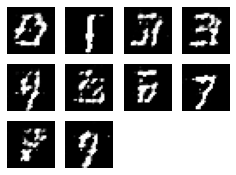

Time for epoch 4 is 13.35569167137146 sec


In [ ]:
EPOCHS = 50
cgan.train(train_dataset, EPOCHS)

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)